In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [95]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from helpers.variable_interfaces import all_variables as vars
from setup.materials_setup import retrieve_cases
from setup.data_wrangle2 import *
from analysis.helpers import map_zone_names, extract_times
from analysis.plot_helpers import set_axis_ticks
# from analysis.dataframes import *
# from analysis.volumes import *
from analysis2.all_cases_v_time import *
sns.set_style("darkgrid")

import polars.selectors as cs
import matplotlib.ticker as ticker

In [96]:
cases = retrieve_cases()

In [97]:
medium_cases = [i for i in cases if "Medium" in i.case_name]
[case] = [i for i in medium_cases if "bol" in i.case_name]
case

CaseData(case_name='Medium_case_bol_5', idf=<geomeppy.idf.IDF object at 0x178a073a0>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_bol_5/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_bol_5'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_bol_5'))

In [98]:
av = vars.afn
qois = [
    av.linkage["flow12"],
    av.linkage["flow21"],
]

df = create_wide_dataframe_for_many_qois(case, qois)
df = extract_times(df)
df.head(2)

case_names,space_names,datetimes,AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s],AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s],time
str,str,datetime[μs],f64,f64,str
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:00:00,0.452094,0.0,"""00:00"""
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:15:00,0.378136,0.0,"""00:15"""


In [99]:
df["space_names"].unique().to_list()

['BLOCK 01 STOREY 0 WALL 0001 WINDOW',
 'BLOCK 06 STOREY 0 WALL 0002_1 DOOR',
 'BLOCK 05 STOREY 0 WALL 0002_2 DOOR',
 'BLOCK 01 STOREY 0 WALL 0002 WINDOW',
 'BLOCK 00 STOREY 0 WALL 0002 WINDOW',
 'BLOCK 01 STOREY 0 WALL 0004 WINDOW',
 'BLOCK 00 STOREY 0 WALL 0003 WINDOW',
 'BLOCK 05 STOREY 0 WALL 0004 WINDOW',
 'BLOCK 06 STOREY 0 WALL 0001_1',
 'BLOCK 05 STOREY 0 WALL 0003 WINDOW']

In [100]:
df = df.with_columns(net_linkage=pl.col("AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s]") - pl.col("AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s]") ) # TODO 
df.head()

case_names,space_names,datetimes,AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s],AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s],time,net_linkage
str,str,datetime[μs],f64,f64,str,f64
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:00:00,0.452094,0.0,"""00:00""",0.452094
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:15:00,0.378136,0.0,"""00:15""",0.378136
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:30:00,0.319479,0.00164,"""00:30""",0.317839
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:45:00,0.255134,0.024292,"""00:45""",0.230842
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 01:00:00,0.251325,0.014399,"""01:00""",0.236926


In [101]:
def get_zones(name):
    return " ".join(name.split(" ")[0:2])

df = df.with_columns(zone_names=pl.col("space_names").map_elements(get_zones, return_dtype=pl.String))
df.head(2)

case_names,space_names,datetimes,AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s],AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s],time,net_linkage,zone_names
str,str,datetime[μs],f64,f64,str,f64,str
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:00:00,0.452094,0.0,"""00:00""",0.452094,"""BLOCK 01"""
"""Medium_case_bol_5""","""BLOCK 01 STOREY 0 WALL 0001 WI…",2017-07-01 00:15:00,0.378136,0.0,"""00:15""",0.378136,"""BLOCK 01"""


In [102]:
linkages = "AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s]", "AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s]"
df_long = df.unpivot(index=["datetimes", "zone_names", "time"], on=linkages, variable_name="linkage12or21", value_name="flow_rate")

df_zones_long = df_long.group_by(["zone_names", "time", "datetimes", "linkage12or21"]).agg(pl.col("flow_rate").sum()).sort(by=["datetimes","zone_names"])
df_zones_long 

zone_names,time,datetimes,linkage12or21,flow_rate
str,str,datetime[μs],str,f64
"""BLOCK 00""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.62143
"""BLOCK 00""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 1 to Node 2 V…",0.007564
"""BLOCK 01""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.426083
"""BLOCK 01""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 1 to Node 2 V…",1.025844
"""BLOCK 05""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 1 to Node 2 V…",0.675585
…,…,…,…,…
"""BLOCK 01""","""23:45""",2017-07-01 23:45:00,"""AFN Linkage Node 1 to Node 2 V…",1.108295
"""BLOCK 05""","""23:45""",2017-07-01 23:45:00,"""AFN Linkage Node 1 to Node 2 V…",0.648412
"""BLOCK 05""","""23:45""",2017-07-01 23:45:00,"""AFN Linkage Node 2 to Node 1 V…",0.648412


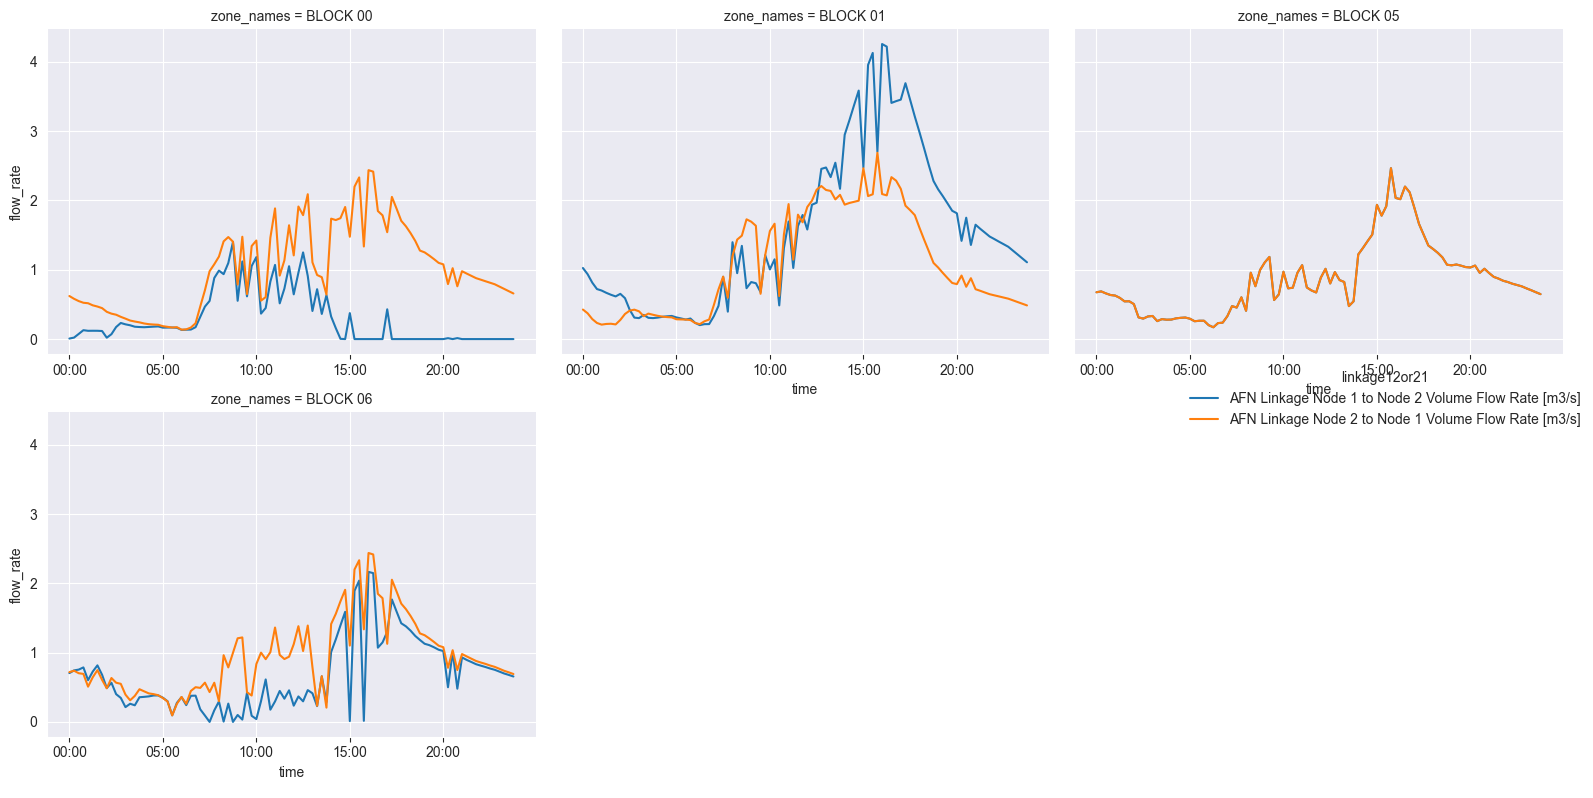

In [103]:
g = sns.relplot(df_zones_long, x="time", y="flow_rate",  col="zone_names", col_wrap=3, height=4,  kind="line", errorbar=None, hue="linkage12or21", hue_order=linkages,)
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
g.add_legend(loc="lower right")

In [104]:
df_zones = df.group_by(["zone_names", "time", "datetimes" ]).agg(pl.col("net_linkage").sum()).sort(by="datetimes")

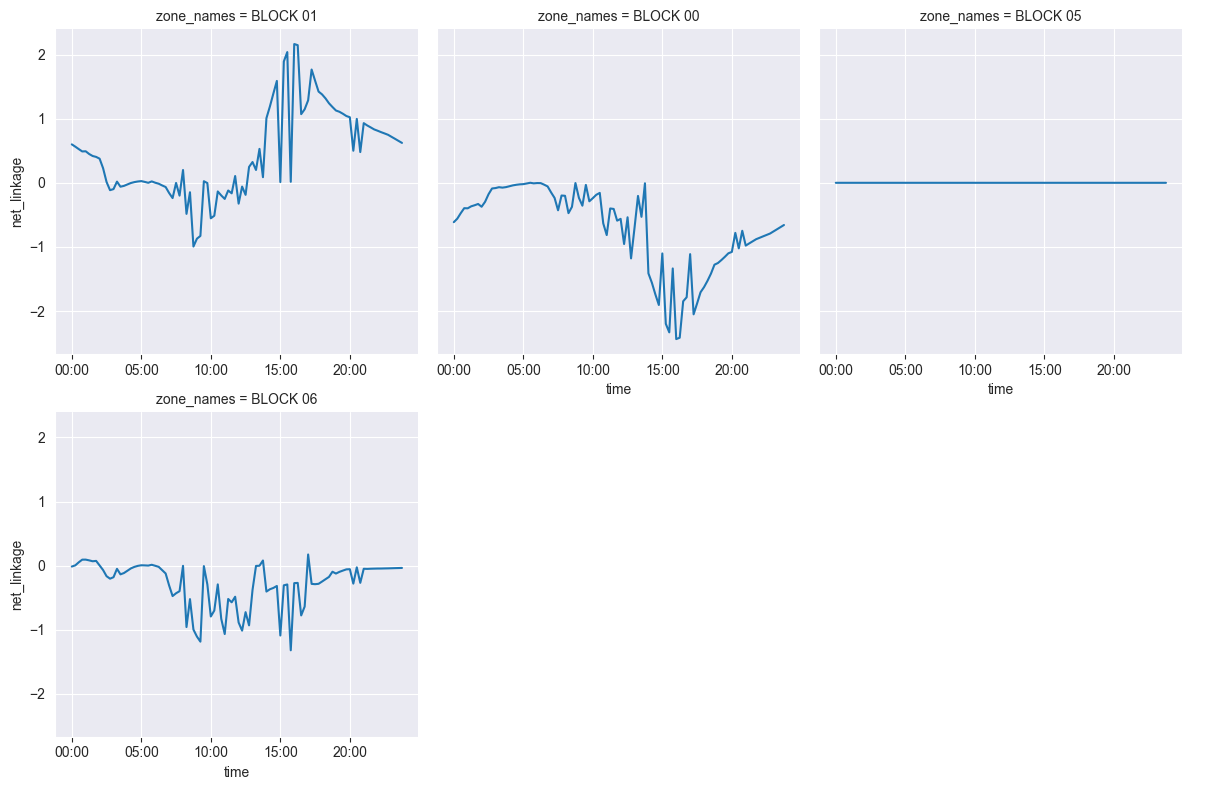

In [105]:
g = sns.relplot(df_zones, x="time", y="net_linkage",  col="zone_names", col_wrap=3, height=4,  kind="line", errorbar=None, )
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
g.add_legend(loc="lower right")